# 1. Data

In [19]:
import numpy as np 
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "data/"]).decode("utf8"))

download
submissionFile
test_text
test_variants
training_text
training_variants



In [20]:
training_text_path = "data/training_text"
test_text_path = "data/test_text"
training_variants_path = "data/training_variants"
test_variants = "data/test_variants"

In [21]:
train_variants_df = pd.read_csv(training_variants_path)
test_variants_df = pd.read_csv(test_variants)
train_text_df = pd.read_csv(training_text_path, sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv(test_text_path, sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

In [22]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [23]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# 2. Data Preparation

## Merge training data

In [24]:
merged_training_df = train_variants_df.merge(train_text_df, left_on="ID", right_on="ID")

In [25]:
merged_training_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


## Merge test data

In [26]:
merged_test_df = test_variants_df.merge(test_text_df, left_on="ID", right_on="ID")

In [27]:
merged_test_df.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


## TF-IDF

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=5, max_features=16000, strip_accents='unicode', lowercase=True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english'
)

In [30]:
tfidf_vectorizer.fit(merged_training_df['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=16000, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

# 3. Evaluation

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import scikitplot.plotters as skplt
%matplotlib inline

In [40]:
X_train_tfidfmatrix = tfidf_vectorizer.transform(merged_training_df['Text'].values)
X_test_tfidfmatrix = tfidf_vectorizer.transform(merged_test_df['Text'].values)

y_train = merged_training_df['Class'].values

In [48]:
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy with 5-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

## Logistic Regression

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.3s finished


Log loss: 1.4895056025755071
Accuracy: 0.4832881662149955


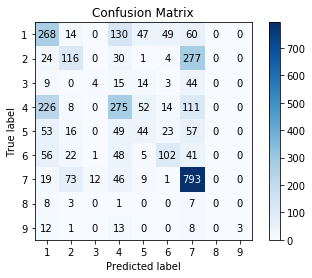

In [49]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=LogisticRegression())

## XGBClassifier  (https://github.com/dmlc/xgboost)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.4min finished


Log loss: 1.4820755772407104
Accuracy: 0.5001505570611262


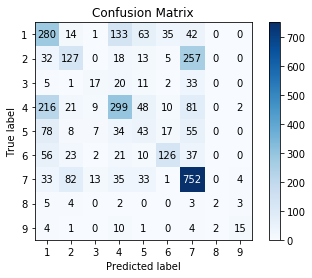

In [50]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=XGBClassifier())

## LightGBM (https://github.com/Microsoft/LightGBM)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.0min finished


Log loss: 1.6993269421952157
Accuracy: 0.47305028605841615


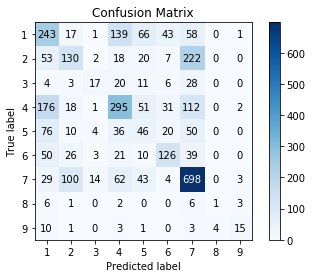

In [51]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=LGBMClassifier())

## Adaboost

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Log loss: 2.0670123824071664
Accuracy: 0.3685636856368564


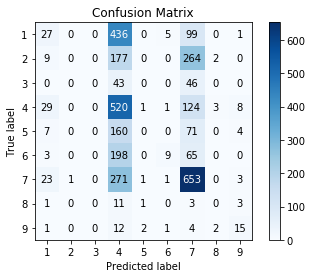

In [52]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=AdaBoostClassifier())

## Random Forest

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   58.3s finished


Log loss: 7.155271713274415
Accuracy: 0.4245709123757904


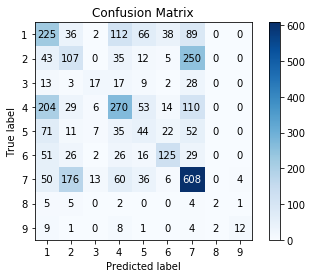

In [53]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=RandomForestClassifier())

## Naive Bayes

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Log loss: 2.7325740852820717
Accuracy: 0.4555856669677808


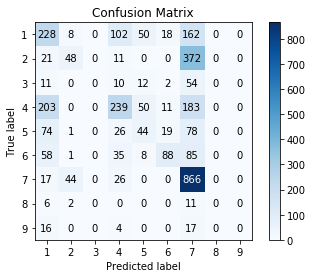

In [54]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=MultinomialNB())

## SVM

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 32.4min finished


Log loss: 1.6467649189466804
Accuracy: 0.40439626618488406


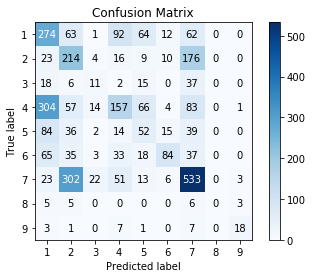

In [55]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=svm.SVC(probability=True))

## Linear SVM

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.3min finished


Log loss: 1.6013394846390399
Accuracy: 0.43932550436615475


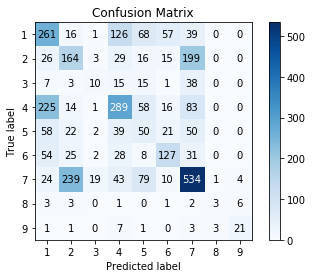

In [56]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=svm.SVC(kernel='linear', probability=True))

## KNeighborsClassifier

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.1s finished


Log loss: 9.933519108722288
Accuracy: 0.3769948810599217


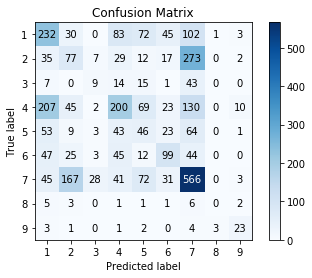

In [57]:
evaluate_features(X_train_tfidfmatrix, y_train, clf=KNeighborsClassifier(n_neighbors=9))

# 4. Training

In [58]:
clf = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
clf.fit(X_train_tfidfmatrix, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [59]:
y_test_predicted = clf.predict_proba(X_test_tfidfmatrix)

# 5. Create Submission File

In [60]:
submission_df = pd.DataFrame(y_test_predicted, columns=['class' + str(c + 1) for c in range(9)])
submission_df['ID'] = merged_test_df['ID']

In [61]:
submission_df.head()

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.022895,0.150710,0.005955,0.015253,0.011332,0.010897,0.781144,0.001469,0.000346,0
1,0.127335,0.092916,0.000946,0.645581,0.016776,0.020649,0.094206,0.001140,0.000451,1
2,0.045042,0.297412,0.002956,0.053230,0.016962,0.016409,0.567414,0.000313,0.000262,2
3,0.022925,0.306977,0.008974,0.069997,0.035874,0.033171,0.520298,0.000914,0.000869,3
4,0.297839,0.096195,0.001049,0.365038,0.024278,0.079536,0.131771,0.001543,0.002750,4


In [62]:
submission_df.to_csv('submission.csv', index=False)